In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import keras
from tensorflow.python.framework import ops
from utils import *
import json
from datetime import datetime

In [6]:
data_path = r"Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\testData.mat"
mechFreq, optFreq, mechQ, optQ, paramsMat = load_data(data_path)

paramsShape = np.shape(paramsMat)[:-1]
num_examples = np.shape(paramsMat)[-1]
optQ_linearized = np.log(optQ)

paramsMat_transposed = tf.transpose(paramsMat, perm = [3, 0, 1, 2])
print("shape of paramsMat_transposed: \t", np.shape(paramsMat_transposed))

print("shape of optQ: \t", np.shape(optQ))

print("number of training examples: \t", num_examples)

Loading data from:  Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\testData.mat 

shape of paramsMat_transposed: 	 (911, 11, 18, 3)
shape of optQ: 	 (911, 1)
number of training examples: 	 911


Text(0, 0.5, 'occurences in data set')

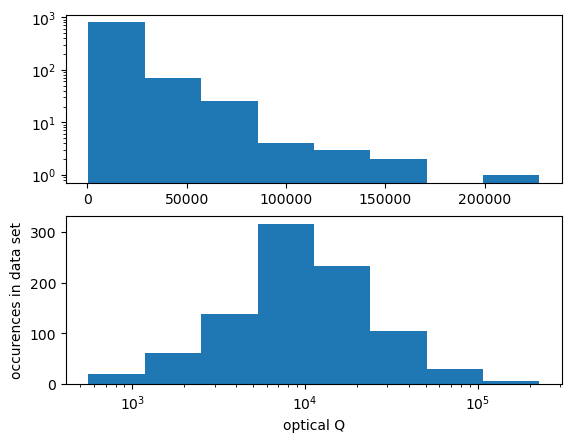

In [15]:
# looking at the data a bit:

x = optQ
# histogram on linear scale
plt.subplot(211)
hist, bins, _ = plt.hist(x, bins=8)
plt.yscale('log')

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.xlabel("optical Q")
plt.ylabel('occurences in data set')

Split the data into train and test sets using tensorflow. Because optical Q is generally sampled logrithmically, to train with a linear activation in the last layer we should take the log of the optical Q data before giving it to the model.

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((paramsMat_transposed, optQ_linearized))

# Shuffle and split the dataset
train_size = int(0.8 * num_examples)
train_dataset = dataset.shuffle(buffer_size=num_examples).take(train_size)
test_dataset = dataset.skip(train_size)

# Example of batching the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Define the model

In [93]:
# define the model using the functional API structure rather than teh sequential structure in order to make it more flexible in the future.

def CNN_model(input_shape, kernel_size = [6, 2], pool_size = [8, 4], FC_nodes = [10]):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE

    Arguments:
    input_img -- input dataset, of shape (input_shape)
    kernel_size -- list of kernel sizes for each Conv2D step
    pool_size -- list of pool sizes for each MaxPool2D step

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)

    Z1 = tfl.Conv2D(filters = 8, kernel_size = (kernel_size[0], kernel_size[0]), strides = 1, padding = 'same')(input_img)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size = (pool_size[0], pool_size[0]), strides = 2, padding = 'same')(A1)
    
    Z2 = tfl.Conv2D(filters = 16, kernel_size = (kernel_size[1], kernel_size[1]), strides = 1, padding = 'same')(P1)
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D(pool_size = (pool_size[1], pool_size[1]), strides = 1, padding = 'same')(A2)
    
    F = tfl.Flatten()(P2)

    A3 = tfl.Dense(FC_nodes[0], activation = 'relu')(F)

    output = tfl.Dense(1)(A3)
    
    model = tf.keras.Model(inputs=input_img, outputs=output)
    return model

In [94]:
conv_model = CNN_model(paramsShape)
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
conv_model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics =['mse'])

conv_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 11, 18, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 11, 18, 8)           │             872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_30 (ReLU)                      │ (None, 11, 18, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 6, 9, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 6, 9, 16)            │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_31 (ReLU)                      │ (None, 6, 9, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 6, 9, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 864)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │           8,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,061 (39.30 KB)

 Trainable params: 10,061 (39.30 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 27.8792 - mse: 27.8792 - val_loss: 2.1449 - val_mse: 2.1449
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7996 - mse: 1.7996 - val_loss: 1.0429 - val_mse: 1.0429
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0881 - mse: 1.0881 - val_loss: 0.9598 - val_mse: 0.9598
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1950 - mse: 1.1950 - val_loss: 1.2035 - val_mse: 1.2035
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1249 - mse: 1.1249 - val_loss: 1.0389 - val_mse: 1.0389
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1777 - mse: 1.1777 - val_loss: 1.0427 - val_mse: 1.0427
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9418 - mse: 0.9418 - val_loss: 1.1704 - val_mse: 1.1704
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9941 - mse: 0.9941 - val_loss: 0.9707 - val_mse: 0.9707
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0

In [67]:
conv_model.evaluate(test_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4368 - mse: 0.4368


[0.40938955545425415, 0.40938955545425415]

Index(['loss', 'mse', 'val_loss', 'val_mse'], dtype='object')


C:\Users\Linus\AppData\Local\Temp\ipykernel_33724\747123822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\Linus\AppData\Local\Temp\ipykernel_33724\747123822.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

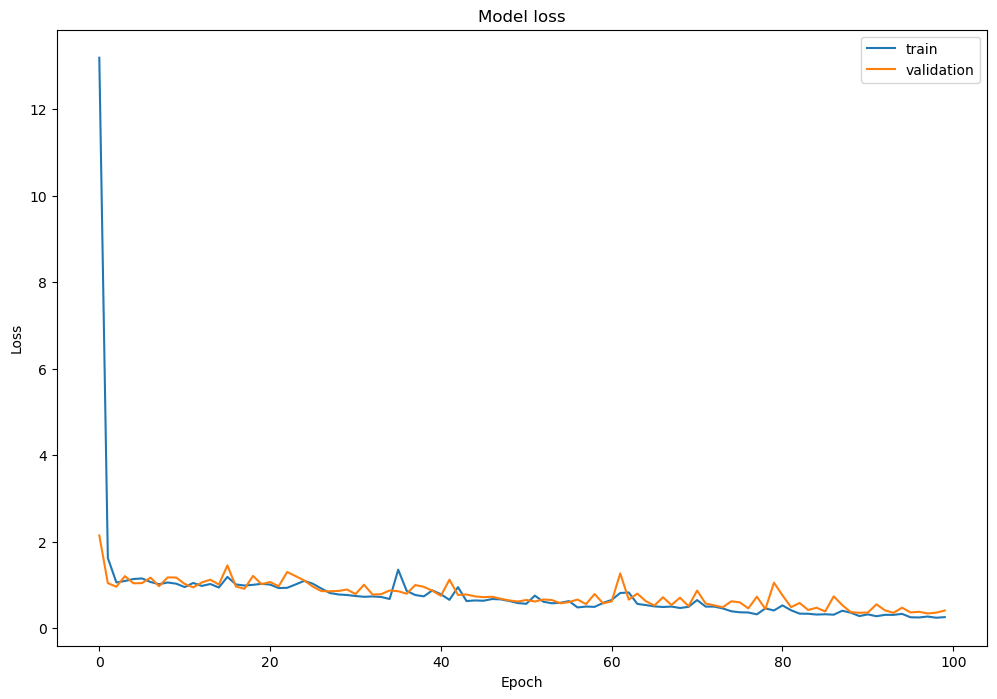

In [68]:
df_loss_acc = pd.DataFrame(history.history)
print(df_loss_acc.columns)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_mse= df_loss_acc[['mse','val_mse']]
df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)

df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
# df_mse.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='MSE')

With a trained model in hand it might be nice to see individual examples of how good it is at predicting...

In [69]:
train_numbers = np.arange(10)
for train_number in train_numbers:
    test_iterator = iter(test_dataset)
    
    # Get a single batch (you can also use next(test_iterator) for just one item in the batch)
    batch_X, batch_Y = next(test_iterator)
    
    # Extract a single input and label pair from the batch
    # For example, take the first item from the batch
    single_input = batch_X[train_number].numpy()  # Convert to NumPy array
    single_label = batch_Y[train_number].numpy()  # Convert to NumPy array
    
    single_input =  np.expand_dims(single_input, axis=0) 
    
    prediction = conv_model.predict(single_input)
    
    print("predicted Q = {}".format(np.exp(prediction)))
    print("true Q = {}".format(np.exp(single_label)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
predicted Q = [[2113.62]]
true Q = [1764.473252]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[6315.2036]]
true Q = [10275.52294081]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[1875.7639]]
true Q = [3040.12035094]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[4212.159]]
true Q = [12165.39992799]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
predicted Q = [[520.87714]]
true Q = [900.82855068]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[8942.716]]
true Q = [8187.85774313]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[12601.296]]
true Q = [24255.90580533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[26304.266]]
true Q = [10110.06770586]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[12526.242]]
true Q = [17853.10393943]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[4684.145]]
true Q = [5647.03080601]


Seems like the model is having a hard time with large Q modes and low Q modes.  Need to think about good ways to give these outliers appropriate weight. ie. model is high bias currently.  however, gets the MSE down below 1 so we are consistently within an order of magnitude ~ this is sort of good.

## parametrizing the model for a random hyperparam search

In [233]:
def hyper_param_search(kernel_sizes, filters, pool_sizes, FC_nodes, lr):
    """
    takes hyperparameters as input, then initializes and trains a model.
    _____________________________________________________________________
    Inputs:
        kernel_sizes - the kernel sizes for each convolutional layer
        filters - the number of filters used for each convolutional layer
        pool_size - the pool size for max pool operations between convolutions
        FC_node - the number of nodes in each dense layer of the model
        lr - the learning rate for the adam optimizer
    Outputs:
        performance - the performance of the trained model on the dev dataset
    """

    def CNN_model(input_shape, kernel_sizes = [6, 2], filters = [8, 16], pool_sizes = [8, 4], FC_nodes = [10]):
        """
        Implements the forward propagation for the model:
        CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
        Arguments:
        input_img -- input dataset, of shape (input_shape)
        kernel_size -- list of kernel sizes for each Conv2D step
        pool_size -- list of pool sizes for each MaxPool2D step
    
        Returns:
        model -- TF Keras model (object containing the information for the entire training process) 
        """
    
        input_img = tf.keras.Input(shape=input_shape)
    
        P = input_img
        
        for kernel_size, num_filters, pool_size in zip(kernel_sizes, filters, pool_sizes):
            Z = tfl.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size), strides = 1, padding = 'same')(P)
            A = tfl.ReLU()(Z)
            P = tfl.MaxPool2D(pool_size = (pool_size, pool_size), strides = 2, padding = 'same')(A)
        
        F = tfl.Flatten()(P)
        A = F

        for node in FC_nodes:
            A = tfl.Dense(node, activation = 'relu')(F)
    
        output = tfl.Dense(1)(A)
        
        model = tf.keras.Model(inputs=input_img, outputs=output)
        return model
    
    conv_model = CNN_model(paramsShape, kernel_sizes, filters, pool_sizes, FC_nodes)
    optimizer = keras.optimizers.Adam(learning_rate = lr)
    conv_model.compile(optimizer=optimizer,
                      loss='mse',
                      metrics =['mse'])

    history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)
    performance = conv_model.evaluate(test_dataset)
    return performance

In [234]:
def gen_random_hyperparams():
    '''
    generates hyperparameters to feed to the parameterized CNN model
        randomly chooses a number of convolutional + maxpool blocks between 1 and 6
        randomly selects set of conv kernel sizes, max pool sizes, and conv filter numbers
        randomly chooses number of dense layers between 1 and 4
        randomly chooses number of nodes in each dense layer
        randomly selects a learning rate on a log scale in the range 1e-1 to 1e-5

    The parameters are sorted such that the model gets increasingly more channels, the mask for conv and maxpool shrinks
    and the fully connected layers go to fewer and fewer nodes moving from input to output of the model.
    '''
    # number of conv + pool layers there will be, between 1 and 6
    num_conv_itters = np.random.randint(1, 6)

    # create list of random integers for the kernel sizes, pool sizes, and num_filers.  The filter numbers should increase
    # while the kernel sizes and pool sizes should decrease.
    kernel_sizes = [np.random.randint(1, 11) for _ in range(num_conv_itters)] # 11 is natural upper bound as this is the dimension of the input on one axis
    kernel_sizes = sorted(kernel_sizes, reverse=True)

    pool_sizes = [np.random.randint(1, 11) for _ in range(num_conv_itters)] # 11 is natural upper bound as this is the dimension of the input on one axis
    pool_sizes = sorted(pool_sizes, reverse=True)

    filters = [np.random.randint(1, 25) for _ in range(num_conv_itters)] # the filters should be sorted starting with fewer filters and going to more
    filters = sorted(filters, reverse=False)

    num_dense_itters = np.random.randint(1, 4)
    FC_nodes = [2**np.random.randint(1, 8) for _ in range(num_dense_itters)] # 11 is natural upper bound as this is the dimension of the input on one axis
    FC_nodes = sorted(FC_nodes, reverse=True)

    # randomly generate the learning rate on a log scale
    rng = 4 # range of exponents
    center = 3 # center of distribution
    lr = 10**-(np.random.rand()*rng + (center-rng/2))

    return kernel_sizes, filters, pool_sizes, FC_nodes, lr



# check that this works once.
performance = hyper_param_search(*gen_random_hyperparams())
print(performance)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 56.9822 - mse: 56.9822 - val_loss: 2.3632 - val_mse: 2.3632
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4500 - mse: 3.4500 - val_loss: 1.2250 - val_mse: 1.2250
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1926 - mse: 1.1926 - val_loss: 0.9784 - val_mse: 0.9784
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9990 - mse: 0.9990 - val_loss: 0.9959 - val_mse: 0.9959
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8838 - mse: 0.8838 - val_loss: 0.9799 - val_mse: 0.9799
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9904 - mse: 0.9904 - val_loss: 1.0297 - val_mse: 1.0297
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9973 - mse: 0.9973 - val_loss: 0.9781 - val_mse: 0.9781
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9659 - mse: 0.9659 - val_loss: 0.9889 - val_mse: 0.9889
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9

The below cell crashed the window because my computer ran out of memory.  There must be a way to close the model after running it so that it doesn't continue to eat memory.  The dictionary could also have gotten too big, but this seems highly improbable given python's ability to store large datasets.

In [ ]:
def update_hyperparams(hyperparams, params):
    '''
    adds row containing 'params' to the hyperparams dictionary

    params - tuple of form (kernel_sizes, filters, pool_sizes, FC_nodes, lr)
    '''
    for val, key in zip(params, hyperparams.keys()):
        hyperparams[key].append(val)

savepath = 'CNN_Optical_Q_hyperparams_{}.json'.format(datetime.now().strftime("%Y%m%d-%H%M%S"))


hyperparams = {"kernel_sizes":[], "filters":[], "pool_sizes":[], "FC_nodes":[], "lr":[], "performance":[]}
for i in range(400):
    print(f'starting parameter combination {i}')
    params = gen_random_hyperparams()
    performance = hyper_param_search(*params)
    params = list(params)
    params.append(performance)
    update_hyperparams(hyperparams, params)
    write_json(hyperparams, savepath)

starting parameter combination 0
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 85.3273 - mse: 85.3273 - val_loss: 82.7867 - val_mse: 82.7867
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 83.8488 - mse: 83.8488 - val_loss: 82.6949 - val_mse: 82.6949
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 84.0713 - mse: 84.0713 - val_loss: 82.6029 - val_mse: 82.6029
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 83.5755 - mse: 83.5755 - val_loss: 82.5109 - val_mse: 82.5109
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 84.5921 - mse: 84.5921 - val_loss: 82.4190 - val_mse: 82.4190
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 84.6149 - mse: 84.6149 - val_loss: 82.3272 - val_mse: 82.3272
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 83.7395 - mse: 83.7395 - val_loss: 82.2354 - val_mse: 82.2354
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 83.6303 - mse: 83.6303 - val_loss: 82.1437 - val_mse: 82.1437

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4257 - mse: 0.4257 - val_loss: 0.5751 - val_mse: 0.5751
Epoch 58/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4008 - mse: 0.4008 - val_loss: 0.5521 - val_mse: 0.5521
Epoch 59/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4741 - mse: 0.4741 - val_loss: 0.5515 - val_mse: 0.5515
Epoch 60/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4835 - mse: 0.4835 - val_loss: 0.5983 - val_mse: 0.5983
Epoch 61/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4333 - mse: 0.4333 - val_loss: 0.5170 - val_mse: 0.5170
Epoch 62/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4745 - mse: 0.4745 - val_loss: 0.5221 - val_mse: 0.5221
Epoch 63/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4001 - mse: 0.4001 - val_loss: 0.5762 - val_mse: 0.5762
Epoch 64/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3842 - mse: 0.3842 - val_loss: 0.5065 - val_mse: 0.5065
Epoch 65/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3927 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8224 - mse: 0.8224 - val_loss: 0.9833 - val_mse: 0.9833
Epoch 63/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9072 - mse: 0.9072 - val_loss: 0.9832 - val_mse: 0.9832
Epoch 64/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8517 - mse: 0.8517 - val_loss: 0.9838 - val_mse: 0.9838
Epoch 65/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9267 - mse: 0.9267 - val_loss: 0.9827 - val_mse: 0.9827
Epoch 66/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9171 - mse: 0.9171 - val_loss: 0.9839 - val_mse: 0.9839
Epoch 67/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9684 - mse: 0.9684 - val_loss: 0.9838 - val_mse: 0.9838
Epoch 68/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9679 - mse: 0.9679 - val_loss: 0.9825 - val_mse: 0.9825
Epoch 69/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9048 - mse: 0.9048 - val_loss: 0.9844 - val_mse: 0.9844
Epoch 70/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9656 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8251 - mse: 0.8251 - val_loss: 0.9776 - val_mse: 0.9776
Epoch 52/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9180 - mse: 0.9180 - val_loss: 0.9698 - val_mse: 0.9698
Epoch 53/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9370 - mse: 0.9370 - val_loss: 0.9626 - val_mse: 0.9626
Epoch 54/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8689 - mse: 0.8689 - val_loss: 0.9887 - val_mse: 0.9887
Epoch 55/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9114 - mse: 0.9114 - val_loss: 0.9659 - val_mse: 0.9659
Epoch 56/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9806 - mse: 0.9806 - val_loss: 0.9765 - val_mse: 0.9765
Epoch 57/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0003 - mse: 1.0003 - val_loss: 1.0524 - val_mse: 1.0524
Epoch 58/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9433 - mse: 0.9433 - val_loss: 0.9938 - val_mse: 0.9938
Epoch 59/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9243 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1192 - mse: 0.1192 - val_loss: 0.2199 - val_mse: 0.2199
Epoch 89/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1529 - mse: 0.1529 - val_loss: 0.1774 - val_mse: 0.1774
Epoch 90/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1124 - mse: 0.1124 - val_loss: 0.1644 - val_mse: 0.1644
Epoch 91/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1253 - mse: 0.1253 - val_loss: 0.1989 - val_mse: 0.1989
Epoch 92/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1002 - mse: 0.1002 - val_loss: 0.1949 - val_mse: 0.1949
Epoch 93/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1391 - mse: 0.1391 - val_loss: 0.1536 - val_mse: 0.1536
Epoch 94/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1141 - mse: 0.1141 - val_loss: 0.1463 - val_mse: 0.1463
Epoch 95/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1422 - mse: 0.1422 - val_loss: 0.1839 - val_mse: 0.1839
Epoch 96/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1310 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8590 - mse: 0.8590 - val_loss: 0.9847 - val_mse: 0.9847
Epoch 92/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8575 - mse: 0.8575 - val_loss: 0.9723 - val_mse: 0.9723
Epoch 93/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8417 - mse: 0.8417 - val_loss: 0.9760 - val_mse: 0.9760
Epoch 94/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9232 - mse: 0.9232 - val_loss: 0.9596 - val_mse: 0.9596
Epoch 95/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8825 - mse: 0.8825 - val_loss: 1.0163 - val_mse: 1.0163
Epoch 96/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8548 - mse: 0.8548 - val_loss: 0.9974 - val_mse: 0.9974
Epoch 97/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9280 - mse: 0.9280 - val_loss: 0.9650 - val_mse: 0.9650
Epoch 98/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9491 - mse: 0.9491 - val_loss: 0.9870 - val_mse: 0.9870
Epoch 99/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7816 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.9048 - mse: 24.9048 - val_loss: 21.6443 - val_mse: 21.6443
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.9996 - mse: 21.9996 - val_loss: 18.7804 - val_mse: 18.7804
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.8789 - mse: 18.8789 - val_loss: 16.2519 - val_mse: 16.2519
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.2140 - mse: 16.2140 - val_loss: 14.0204 - val_mse: 14.0204
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.4521 - mse: 14.4521 - val_loss: 12.0604 - val_mse: 12.0604
Epoch 16/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.7458 - mse: 11.7458 - val_loss: 10.3695 - val_mse: 10.3695
Epoch 17/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.1871 - mse: 11.1871 - val_loss: 8.8723 - val_mse: 8.8723
Epoch 18/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9136 - mse: 8.9136 - val_loss: 7.5949 - val_mse: 7.5949
Epoch 19/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2406 - mse: 0.2406 - val_loss: 0.4205 - val_mse: 0.4205
Epoch 88/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2053 - mse: 0.2053 - val_loss: 0.4055 - val_mse: 0.4055
Epoch 89/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2253 - mse: 0.2253 - val_loss: 0.4652 - val_mse: 0.4652
Epoch 90/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2267 - mse: 0.2267 - val_loss: 0.4190 - val_mse: 0.4190
Epoch 91/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2188 - mse: 0.2188 - val_loss: 0.3700 - val_mse: 0.3700
Epoch 92/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2856 - mse: 0.2856 - val_loss: 0.3213 - val_mse: 0.3213
Epoch 93/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2488 - mse: 0.2488 - val_loss: 0.2835 - val_mse: 0.2835
Epoch 94/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2025 - mse: 0.2025 - val_loss: 0.3462 - val_mse: 0.3462
Epoch 95/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2747 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9515 - mse: 0.9515 - val_loss: 0.9869 - val_mse: 0.9869
Epoch 76/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9402 - mse: 0.9402 - val_loss: 0.9859 - val_mse: 0.9859
Epoch 77/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9721 - mse: 0.9721 - val_loss: 0.9859 - val_mse: 0.9859
Epoch 78/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8912 - mse: 0.8912 - val_loss: 0.9867 - val_mse: 0.9867
Epoch 79/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9005 - mse: 0.9005 - val_loss: 0.9862 - val_mse: 0.9862
Epoch 80/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0357 - mse: 1.0357 - val_loss: 0.9871 - val_mse: 0.9871
Epoch 81/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8763 - mse: 0.8763 - val_loss: 0.9868 - val_mse: 0.9868
Epoch 82/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8891 - mse: 0.8891 - val_loss: 0.9887 - val_mse: 0.9887
Epoch 83/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9184 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8746 - mse: 0.8746 - val_loss: 0.9137 - val_mse: 0.9137
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9206 - mse: 0.9206 - val_loss: 0.9646 - val_mse: 0.9646
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9590 - mse: 0.9590 - val_loss: 0.8974 - val_mse: 0.8974
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9896 - mse: 0.9896 - val_loss: 1.3297 - val_mse: 1.3297
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0343 - mse: 1.0343 - val_loss: 0.9102 - val_mse: 0.9102
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8506 - mse: 0.8506 - val_loss: 0.8827 - val_mse: 0.8827
Epoch 16/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9196 - mse: 0.9196 - val_loss: 0.9066 - val_mse: 0.9066
Epoch 17/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8378 - mse: 0.8378 - val_loss: 0.9153 - val_mse: 0.9153
Epoch 18/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8474 - 

In [3]:
path = "CNN_Optical_Q_hyperparams_20241112-212236.json"

loaded_data = read_json(path)

print("Loaded data:", pd.DataFrame(loaded_data))
df = pd.DataFrame(loaded_data)
df.to_csv(path.split()[0] + '.csv')

Loaded data:           kernel_sizes              filters        pool_sizes     FC_nodes  \
0           [10, 6, 4]          [7, 10, 16]         [9, 8, 7]   [64, 8, 2]   
1              [10, 5]             [15, 16]           [10, 3]          [4]   
2            [5, 4, 2]         [15, 18, 21]         [3, 2, 1]  [128, 2, 2]   
3         [5, 4, 4, 3]      [7, 11, 12, 22]     [10, 8, 5, 3]    [8, 8, 4]   
4    [10, 10, 4, 2, 1]    [1, 1, 9, 19, 21]  [10, 8, 7, 7, 6]     [64, 32]   
..                 ...                  ...               ...          ...   
395       [9, 8, 6, 6]      [6, 11, 17, 20]      [9, 7, 5, 4]  [64, 16, 2]   
396                [4]                 [19]               [5]  [64, 16, 2]   
397       [9, 9, 5, 4]         [1, 3, 8, 9]     [10, 8, 3, 3]          [4]   
398               [10]                 [19]               [5]         [32]   
399    [7, 5, 3, 2, 1]  [5, 10, 14, 15, 20]   [9, 8, 6, 5, 4]   [16, 8, 2]   

           lr                                   pe

In [9]:
## best performer from CNN_Optical_Q_hyperparams_20241112-212236.json

kernel_sizes, filters, pool_sizes, FC_nodes, lr = [10, 10], [23, 24], [10, 2], [64], 0.0019715835257217303
def CNN_model(input_shape, kernel_sizes = [6, 2], filters = [8, 16], pool_sizes = [8, 4], FC_nodes = [10]):
        """
        Implements the forward propagation for the model:
        CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
        Arguments:
        input_img -- input dataset, of shape (input_shape)
        kernel_size -- list of kernel sizes for each Conv2D step
        pool_size -- list of pool sizes for each MaxPool2D step
    
        Returns:
        model -- TF Keras model (object containing the information for the entire training process) 
        """
    
        input_img = tf.keras.Input(shape=input_shape)
    
        P = input_img
        
        for kernel_size, num_filters, pool_size in zip(kernel_sizes, filters, pool_sizes):
            Z = tfl.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size), strides = 1, padding = 'same')(P)
            A = tfl.ReLU()(Z)
            P = tfl.MaxPool2D(pool_size = (pool_size, pool_size), strides = 2, padding = 'same')(A)
        
        F = tfl.Flatten()(P)
        A = F

        for node in FC_nodes:
            A = tfl.Dense(node, activation = 'relu')(F)
    
        output = tfl.Dense(1)(A)
        
        model = tf.keras.Model(inputs=input_img, outputs=output)
        return model
    
conv_model = CNN_model(paramsShape, kernel_sizes, filters, pool_sizes, FC_nodes)
optimizer = keras.optimizers.Adam(learning_rate = lr)
conv_model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics =['mse'])

history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)
performance = conv_model.evaluate(test_dataset)

train_numbers = np.arange(10)
for train_number in train_numbers:
    test_iterator = iter(test_dataset)
    
    # Get a single batch (you can also use next(test_iterator) for just one item in the batch)
    batch_X, batch_Y = next(test_iterator)
    
    # Extract a single input and label pair from the batch
    # For example, take the first item from the batch
    single_input = batch_X[train_number].numpy()  # Convert to NumPy array
    single_label = batch_Y[train_number].numpy()  # Convert to NumPy array
    
    single_input =  np.expand_dims(single_input, axis=0) 
    
    prediction = conv_model.predict(single_input)
    
    print("predicted Q = {}".format(np.exp(prediction)))
    print("true Q = {}".format(np.exp(single_label)))

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 22.8618 - mse: 22.8618 - val_loss: 2.2583 - val_mse: 2.2583
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2175 - mse: 1.2175 - val_loss: 1.0112 - val_mse: 1.0112
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9731 - mse: 0.9731 - val_loss: 1.1247 - val_mse: 1.1247
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0694 - mse: 1.0694 - val_loss: 0.9520 - val_mse: 0.9520
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1343 - mse: 1.1343 - val_loss: 1.1339 - val_mse: 1.1339
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1510 - mse: 1.1510 - val_loss: 1.0195 - val_mse: 1.0195
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0351 - mse: 1.0351 - val_loss: 1.0777 - val_mse: 1.0777
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9303 - mse: 0.9303 - val_loss: 0.9655 - val_mse: 0.9655
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8

## CNN with dropout
Taking best preforming network and adding dropout to the model to increase generalization.  With this model, seems that we can acuratly predict Q to one significant digit and most of the time to two significant digits.

In [22]:
## best performer from CNN_Optical_Q_hyperparams_20241112-212236.json

kernel_sizes, filters, pool_sizes, FC_nodes, lr = [10, 10], [23, 24], [10, 2], [64], 0.0019715835257217303 * 0.1
def CNN_model_w_dropout(input_shape, kernel_sizes = [6, 2], filters = [8, 16], pool_sizes = [8, 4], FC_nodes = [10]):
        """
        Implements the forward propagation for the model:
        CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
        Arguments:
        input_img -- input dataset, of shape (input_shape)
        kernel_size -- list of kernel sizes for each Conv2D step
        pool_size -- list of pool sizes for each MaxPool2D step
    
        Returns:
        model -- TF Keras model (object containing the information for the entire training process) 
        """
    
        input_img = tf.keras.Input(shape=input_shape)
    
        P = input_img
        
        for kernel_size, num_filters, pool_size in zip(kernel_sizes, filters, pool_sizes):
            Z = tfl.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size), strides = 1, padding = 'same')(P)
            A = tfl.ReLU()(Z)
            P = tfl.MaxPool2D(pool_size = (pool_size, pool_size), strides = 2, padding = 'same')(A)
        
        F = tfl.Flatten()(P)

        D = tfl.Dropout(rate = 0.01)(A)
        A = D
        
        for node in FC_nodes:
            A = tfl.Dense(node, activation = 'relu')(A)
    
        output = tfl.Dense(1)(A)
        
        model = tf.keras.Model(inputs=input_img, outputs=output)
        return model
    
conv_model = CNN_model(paramsShape, kernel_sizes, filters, pool_sizes, FC_nodes)
optimizer = keras.optimizers.Adam(learning_rate = lr)
conv_model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics =['mse'])

history = conv_model.fit(train_dataset, epochs=500, validation_data=test_dataset)
performance = conv_model.evaluate(test_dataset)

train_numbers = np.arange(10)
for train_number in train_numbers:
    test_iterator = iter(test_dataset)
    
    # Get a single batch (you can also use next(test_iterator) for just one item in the batch)
    batch_X, batch_Y = next(test_iterator)
    
    # Extract a single input and label pair from the batch
    # For example, take the first item from the batch
    single_input = batch_X[train_number].numpy()  # Convert to NumPy array
    single_label = batch_Y[train_number].numpy()  # Convert to NumPy array
    
    single_input =  np.expand_dims(single_input, axis=0) 
    
    prediction = conv_model.predict(single_input)
    
    print("predicted Q = {}".format(np.exp(prediction)))
    print("true Q = {}".format(np.exp(single_label)))

Epoch 1/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 67.8189 - mse: 67.8189 - val_loss: 2.5446 - val_mse: 2.5446
Epoch 2/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0043 - mse: 3.0043 - val_loss: 1.8185 - val_mse: 1.8185
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2408 - mse: 1.2408 - val_loss: 0.9755 - val_mse: 0.9755
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9866 - mse: 0.9866 - val_loss: 0.9804 - val_mse: 0.9804
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8745 - mse: 0.8745 - val_loss: 0.9745 - val_mse: 0.9745
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9097 - mse: 0.9097 - val_loss: 0.9743 - val_mse: 0.9743
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8315 - mse: 0.8315 - val_loss: 0.9722 - val_mse: 0.9722
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9555 - mse: 0.9555 - val_loss: 0.9901 - val_mse: 0.9901
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8

In [25]:
weights_path = "CNN_w_dropout_wights.weights.h5"
conv_model.save_weights(weights_path)

In [26]:
blank_model = CNN_model(paramsShape, kernel_sizes, filters, pool_sizes, FC_nodes)
blank_model.compile()
performace = blank_model.evaluate(test_dataset)
print(f'blank model performance {performance}')

loaded_model = CNN_model(paramsShape, kernel_sizes, filters, pool_sizes, FC_nodes)
loaded_model.load_weights(weights_path)
performace =  loaded_model.evaluate(test_dataset)
print(f'loaded model performance {performance}')

ValueError: You must call `compile()` before using the model.

Index(['loss', 'mse', 'val_loss', 'val_mse'], dtype='object')


C:\Users\Linus\AppData\Local\Temp\ipykernel_8704\4250672253.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\Linus\AppData\Local\Temp\ipykernel_8704\4250672253.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)


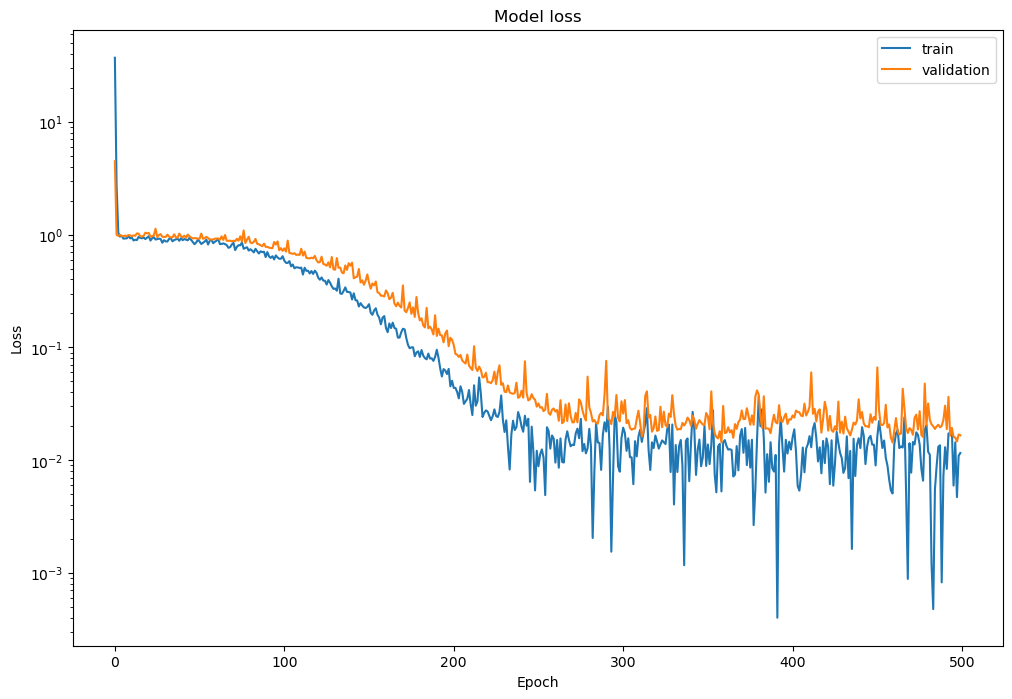

In [19]:
df_loss_acc = pd.DataFrame(history.history)
print(df_loss_acc.columns)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_mse= df_loss_acc[['mse','val_mse']]
df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)

df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
plt.yscale('log')
# df_mse.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='MSE')

In [20]:
train_numbers = np.arange(20)
for train_number in train_numbers:
    test_iterator = iter(test_dataset)
    
    # Get a single batch (you can also use next(test_iterator) for just one item in the batch)
    batch_X, batch_Y = next(test_iterator)
    
    # Extract a single input and label pair from the batch
    # For example, take the first item from the batch
    single_input = batch_X[train_number].numpy()  # Convert to NumPy array
    single_label = batch_Y[train_number].numpy()  # Convert to NumPy array
    
    single_input =  np.expand_dims(single_input, axis=0) 
    
    prediction = conv_model.predict(single_input)
    
    print("predicted Q = {}".format(np.exp(prediction)))
    print("true Q = {}".format(np.exp(single_label)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predicted Q = [[19188.88]]
true Q = [18979.77548522]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predicted Q = [[48918.676]]
true Q = [49243.36569778]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predicted Q = [[7926.5557]]
true Q = [7866.39080575]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted Q = [[8610.146]]
true Q = [9167.0738224]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted Q = [[8597.379]]
true Q = [8730.27137618]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
predicted Q = [[5607.9414]]
true Q = [5796.2399872]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted Q = [[5258.596]]
true Q = [5382.76852792]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted Q = [[1147.1604]]
true Q = [1183.77318019]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted Q = [[20849.686]]
true Q = [21780.798181]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted Q = [[1126.11]]
true Q = [1138.57869454]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predicted Q = [[5688.4907]]
true Q = [6014.83780174]
1/1 ━━